# Nichesphere tutorial (PIC-seq)

Nichesphere is an sc-verse [ref] compatible Python library which allows the user to find differentially colocalised cellular niches based on cell type pairs colocalisation probabilities in different conditions. Cell type pair colocalisation probabilities are obtained from deconvoluted spatial transcriptomics / PIC-seq data (probabilities of finding each cell type in each spot / multiplet).

It also offers the possibility to look at localised differential cell - cell communication based on Ligand-Receptor pairs expression data, such as results from CrossTalkeR [ref].


## Libraries and functions

In [1]:
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
import glob
import matplotlib.pyplot as plt
import networkx as nx
import warnings
import scanpy as sc
import leidenalg
import igraph as ig
import sklearn

warnings.filterwarnings("ignore")

## My package test
import sys
sys.path.append("/home/mayra/source/Nichesphere/nichesphere/")
import nichesphere.tl

Accordion [ref] functions for distances

In [2]:

def get_Q_matrix(M):
    # taken from https://github.com/zboyd2/hitting_probabilities_metric/blob/master/HittingTimes_L3.m
    N = M.shape[0]
    e1 = np.zeros((1, N))
    e1[0][0] = 1
    A1inv = np.eye(N) - M
    A1inv[0, :] = e1
    A1inv = np.linalg.inv(A1inv)
    Q = np.zeros((N, N),dtype='double')
    Q[:, 0] = A1inv[:, 0].reshape(N,) / np.diagonal(A1inv)
    M = M @ A1inv
    detCj = ((1 + np.diagonal(M)) * (1 - M[0, 0])) + np.multiply(M[:, 0],M[0, :].transpose()).reshape(N,)
    CjInv = np.zeros((2, 2, N))
    CjInv[0, 0, :] = (1 - M[0, 0]) / detCj
    CjInv[0, 1, :] = M[:, 0].reshape(N,) / detCj # WAS WRONG INDEX HERE
    CjInv[1, 0, :] = -M[0, :].transpose().reshape(N,) / detCj
    CjInv[1, 1, :] = (1 + np.diagonal(M)) / detCj
    M1 = np.zeros((N, 2, N),dtype='double')
    M1[:, 0, :] = A1inv
    M1[:, 1, :] = np.tile(-A1inv[:, 0],( 1, N)).reshape(N, N)
    M2 = np.zeros((2, N, N),dtype='double')
    M2[0, :, :] = M.transpose()
    M2[1, :, :] = np.tile(M[0, :],(N, 1)).transpose()
    for j in range(1, N):
        # assert np.all(
        #    np.concatenate([A1inv[:, j].reshape((N, 1)), - A1inv[:, 0].reshape((N, 1))], axis=1) == M1[:, :, j])
        Ac = A1inv[:, j].reshape(N,) - np.matmul(np.matmul(M1[:, :, j], CjInv[:, :, j]), M2[:, j, j])
        Ad = np.diagonal(A1inv) - sum(
            M1[:, :, j].transpose() * np.matmul(CjInv[:, :, j], M2[:, :, j]))
        Q[:, j] = Ac / Ad
    np.fill_diagonal(Q, 0)
    return Q  # - np.diagonal(np.diagonal(Q))

In [3]:
### Get distances with accordion
def get_dhp(P, beta=0.5):
    n = P.shape[0]
    # Compute hitting probabilities
    Q = np.round(get_Q_matrix(P),5)
    # Find the invariant measure
    v = eigs(P.T.astype('f'), 
              k=1, 
              sigma=1+1e-6, 
              which='LM',
              tol=1e-3,maxiter=100000,v0=np.ones(n)/n)[1].ravel()
    v1 = np.abs(v)/norm(v,ord=1)
    #v = v-np.min(v) + 1e-10
    # Construct the symmetric adjacency matrix M:
    if beta == 0.5:
        Aht = diags(v1**0.5, 0,(n, n)) @ Q @ diags(v1**-0.5, 0,(n, n))
    elif beta == 1:
        Aht = diags(v1, 0,(n, n)) @ Q 
    else:
        raise ValueError(f"Unsupported beta value: {beta}")
    Aht = (Aht + Aht.T) / 2
    #np.fill_diagonal(Aht, 0)   
    # Compute the hitting probability distance
    dhp = -np.log10(Aht,where=Aht != 0)
    np.fill_diagonal(dhp,0)
    return(np.round(dhp,5)) 

## PIC-seq data at first glance

Cell type proportions in doublets

In [4]:
CTprops=pd.read_csv('./PICseq_doublets_CTprops_BP_annotation_noMSCs_Xist.csv', index_col=0)

Gene expression data

In [5]:
adata_singlets=sc.read('./PICseq_singlets.h5ad')
adata_singlets=adata_singlets[adata_singlets.obs.annotation!='SkletalMusCells'] # These cells were removed as their quality was worse compared to others (less counts)
adata_doublets=sc.read('./PICseq_doublets.h5ad')

Visualize probabilities of cell types across doublets

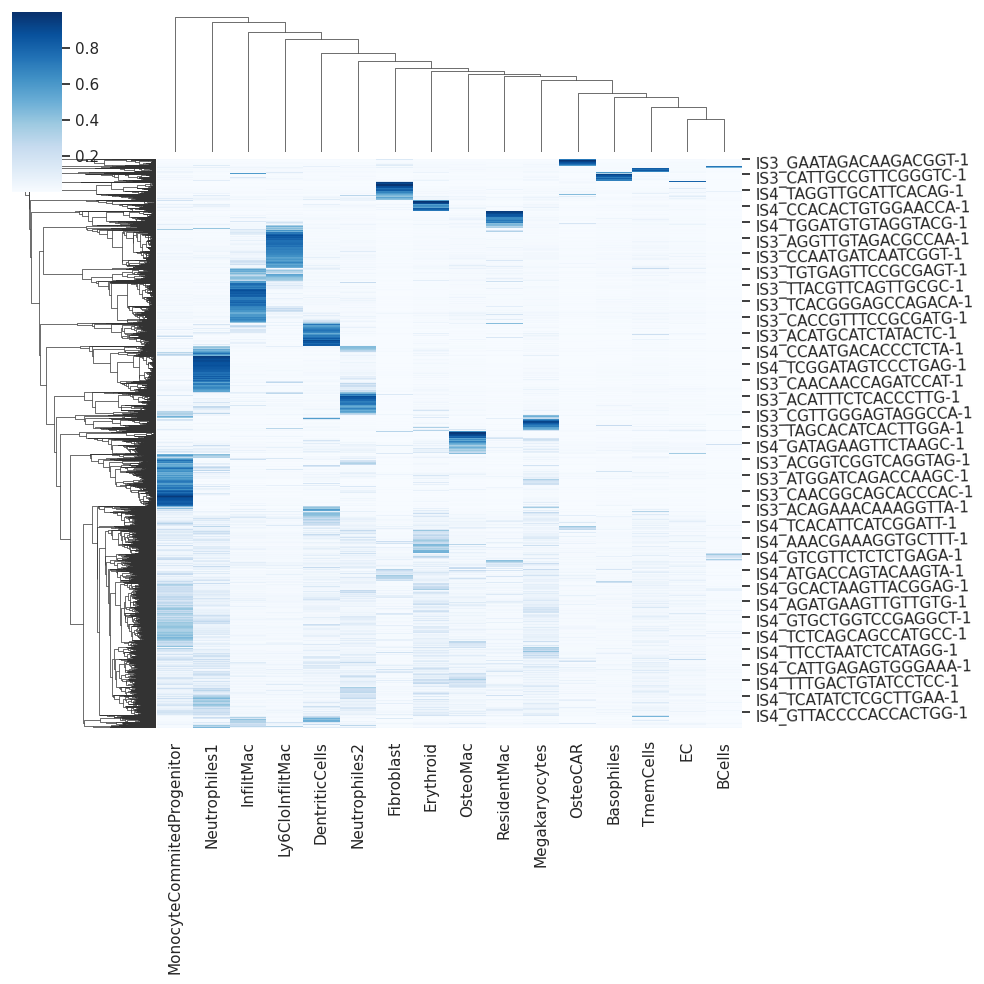

In [6]:
## Heatmap
sns.set(font_scale=1)
heat=sns.clustermap(CTprops, cmap='Blues', method='average')
#plot.set_yticklabels(rotation=90)
plt.setp(heat.ax_heatmap.yaxis.get_majorticklabels(), rotation=1)
plt.savefig('./figures/CTprops_hm.png')
plt.show()

## Colocalisation

We will compute colocalisation probabilities from deconvoluted data files

Here we will get concatenated single colocalisation sample matrices of cell type x cell type.

Deconvoluted data files should be anndata gene expression objects with cell type proportions as obs. We didn't get such files from the BayesPrism deconvolution pipeline, so we will make one per condition as follows:

In [7]:
adata_doubletsTPO=adata_doublets[adata_doublets.obs.stage=='TPO']
adata_doubletsTPO.obs=CTprops.loc[adata_doubletsTPO.obs_names]
adata_doubletsTPO.write_h5ad('PICseq_doublets_TPO.h5ad')

In [8]:
adata_doubletsEV=adata_doublets[adata_doublets.obs.stage=='EV']
adata_doubletsEV.obs=CTprops.loc[adata_doubletsEV.obs_names]
adata_doubletsEV.write_h5ad('PICseq_doublets_EV.h5ad')

Now we can use getColocProbs to get cell type pairs colocalisation probabilities

In [9]:
files = glob.glob('./PICseq_doublets_*.h5ad')

In [10]:
CTcolocalizationP= nichesphere.tl.getColocProbs(filesList=files, filePrefix='./PICseq_doublets_', nCellTypes=16)
CTcolocalizationP

,DentriticCells,InfiltMac,Fibroblast,MonocyteCommitedProgenitor,Neutrophiles2,Ly6CloInfiltMac,Basophiles,TmemCells,Neutrophiles1,Megakaryocytes,ResidentMac,OsteoCAR,EC,Erythroid,OsteoMac,BCells,sample
DentriticCells,0.018899,0.003145,0.002420,0.009168,0.004171,0.001827,0.001256,0.003089,0.006253,0.005446,0.002721,0.001507,0.001714,0.006465,0.003841,0.000943,EV
InfiltMac,0.003145,0.007253,0.001322,0.003761,0.002179,0.001766,0.000631,0.001563,0.002736,0.001967,0.001844,0.000794,0.000946,0.002822,0.002009,0.000496,EV
Fibroblast,0.002420,0.001322,0.020764,0.005082,0.002962,0.001163,0.000904,0.001726,0.004088,0.002725,0.001727,0.002111,0.001767,0.004005,0.002702,0.000876,EV
MonocyteCommitedProgenitor,0.009168,0.003761,0.005082,0.055366,0.011903,0.003358,0.002878,0.005730,0.016713,0.012703,0.004622,0.003131,0.003569,0.014315,0.007889,0.002072,EV
Neutrophiles2,0.004171,0.002179,0.002962,0.011903,0.016147,0.002004,0.001496,0.003008,0.011881,0.004586,0.002610,0.001726,0.001901,0.007352,0.004330,0.001248,EV
Ly6CloInfiltMac,0.001827,0.001766,0.001163,0.003358,0.002004,0.005015,0.000568,0.001305,0.002605,0.001742,0.001836,0.000731,0.000840,0.002550,0.001813,0.000471,EV
Basophiles,0.001256,0.000631,0.000904,0.002878,0.001496,0.000568,0.001543,0.000885,0.002081,0.001533,0.000829,0.000525,0.000555,0.002148,0.001254,0.000338,EV
TmemCells,0.003089,0.001563,0.001726,0.005730,0.003008,0.001305,0.000885,0.005183,0.004209,0.003209,0.001947,0.001029,0.001198,0.004115,0.002629,0.000741,EV
Neutrophiles1,0.006253,0.002736,0.004088,0.016713,0.011881,0.002605,0.002081,0.004209,0.038961,0.006610,0.003526,0.002443,0.002671,0.010066,0.005763,0.001673,EV
Megakaryocytes,0.005446,0.001967,0.002725,0.012703,0.004586,0.001742,0.001533,0.003209,0.006610,0.012212,0.002657,0.001665,0.001897,0.007895,0.004677,0.001140,EV


Same cell type interactions will be excluded later on, so we'll have a list of same cell type interaction pairs in order to subset the colocalisation table we'll generate in the next step.

In [11]:
oneCTints=CTcolocalizationP.columns[range(len(CTcolocalizationP.columns)-1)]+'-'+CTcolocalizationP.columns[range(len(CTcolocalizationP.columns)-1)]

Then we will reshape the colocalisation data into a matrix of cell type pairs x samples

In [12]:
colocPerSample=nichesphere.tl.reshapeColoc(CTcoloc=CTcolocalizationP, complete=1)
colocPerSample.to_csv('./colocPerSample.csv')
colocPerSample

,DentriticCells-DentriticCells,DentriticCells-InfiltMac,DentriticCells-Fibroblast,DentriticCells-MonocyteCommitedProgenitor,DentriticCells-Neutrophiles2,DentriticCells-Ly6CloInfiltMac,DentriticCells-Basophiles,DentriticCells-TmemCells,DentriticCells-Neutrophiles1,DentriticCells-Megakaryocytes,...,BCells-Basophiles,BCells-TmemCells,BCells-Neutrophiles1,BCells-Megakaryocytes,BCells-ResidentMac,BCells-OsteoCAR,BCells-EC,BCells-Erythroid,BCells-OsteoMac,BCells-BCells
EV,0.018899,0.003145,0.002420,0.009168,0.004171,0.001827,0.001256,0.003089,0.006253,0.005446,...,0.000338,0.000741,0.001673,0.001140,0.000657,0.000472,0.000449,0.00168,0.001045,0.004976
TPO,0.043204,0.011930,0.000577,0.007006,0.002704,0.004632,0.001131,0.001506,0.005417,0.004213,...,0.000112,0.000134,0.000347,0.000144,0.000150,0.000077,0.000050,0.00007,0.000078,0.000504


The sum of the probabilities of every cell type pair in a sample must be = 1

In [13]:
colocPerSample.sum(axis=1)

EV     1.0
TPO    1.0
dtype: float64

In this case, we do not have multiple samples from our two different conditions, so we will compute the expected probability of each cell type pair to occur by multiplying cell type proportions from the single cell data:

In [14]:
scCTpairsProbs_TPO=nichesphere.tl.getExpectedColocProbsFromSCs(sc_adata=adata_singlets, sample='TPO', cell_types=CTprops.columns, sc_data_sampleCol='stage', sc_adata_annotationCol='annotation')
scCTpairsProbs_EV=nichesphere.tl.getExpectedColocProbsFromSCs(sc_adata=adata_singlets, sample='EV', cell_types=CTprops.columns, sc_data_sampleCol='stage', sc_adata_annotationCol='annotation')


Differential colocalisation analysis

Here we will test differential colocalisation by generating a distribution of O/E ratios for colocalisation probabilities of cell type pairs in randomly generated doublets (from our singlets data)

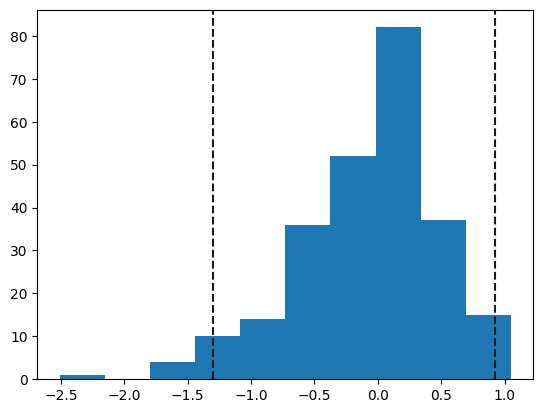

In [15]:
test=nichesphere.tl.PIC_BGdoubletsOEratios(adata_singlets=adata_singlets, nmults=int(np.round(adata_singlets.obs.shape[0]/2)), annot=adata_singlets.obs.annotation, 
                singIDs=adata_singlets.obs.index, sep='-')
plt.style.use('default')
plt.hist(np.log2(test), bins=10)
plt.axvline(np.quantile(np.log2(test), 0.025), color='k', linestyle='dashed')
plt.axvline(np.quantile(np.log2(test), 0.975), color='k', linestyle='dashed')
plt.savefig('./figures/randomDoubletsOEratiosDist.png')
plt.show()

Differential colocalisation will be then significant if the value obtained is among the 0.025 smallest or biggest values in the distribution.
So we will calculate observed / expected ratios, log2 scale them and filter non significant values with the function OvsE_coloc_test.

Then we will plot significant values in a heatmap

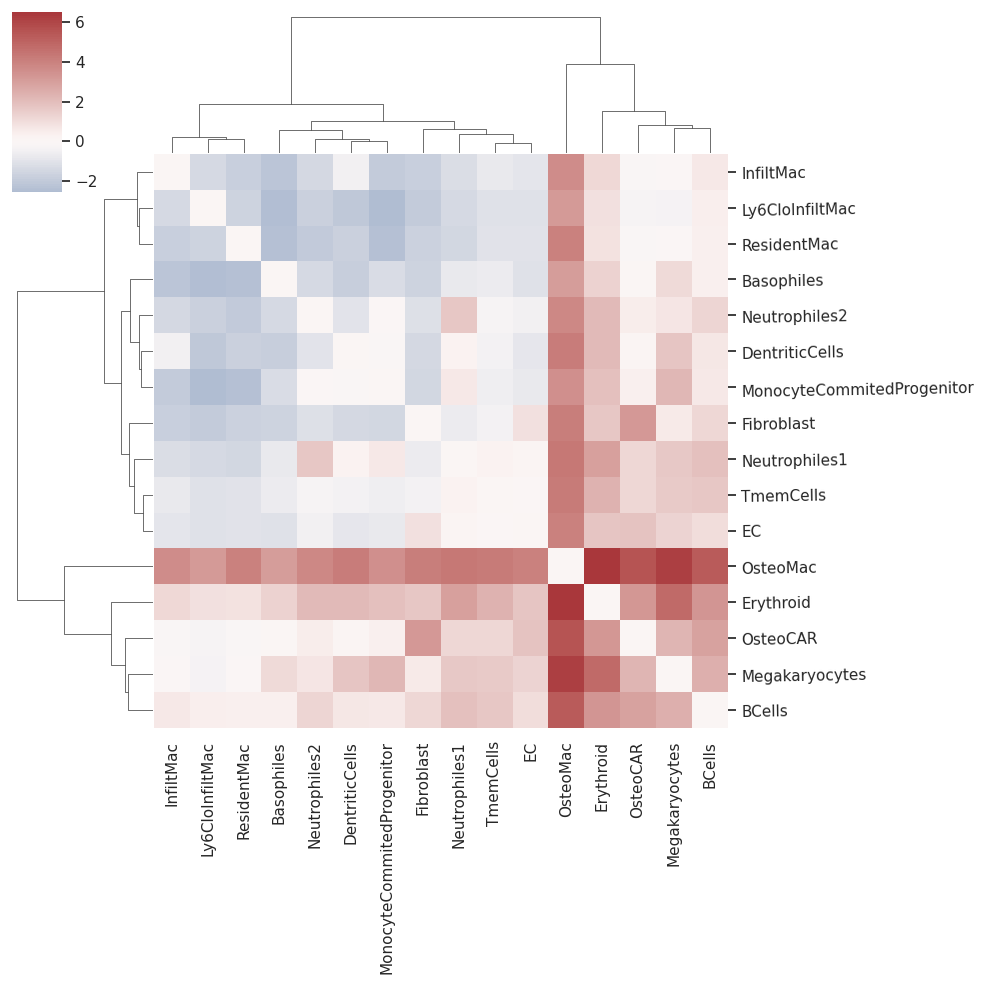

In [16]:
#Unfiltered (To get dendrogram clusters)
OvsE_TPO_HMdf=nichesphere.tl.OvsE_coloc_test(observedColocProbs=colocPerSample.loc['TPO'], expectedColocProbs=scCTpairsProbs_TPO.annotation, cell_types=CTprops.columns, 
                              testDistribution=test, oneCTinteractions=oneCTints, p=1)
## Plot heatmap
sns.set(font_scale=1)
plot=sns.clustermap(OvsE_TPO_HMdf, cmap='vlag', center=0, method='ward')
plt.setp(plot.ax_heatmap.yaxis.get_majorticklabels(), rotation=1)
plt.savefig('./figures/OvsE_TPO_clustered.png')
plt.show()

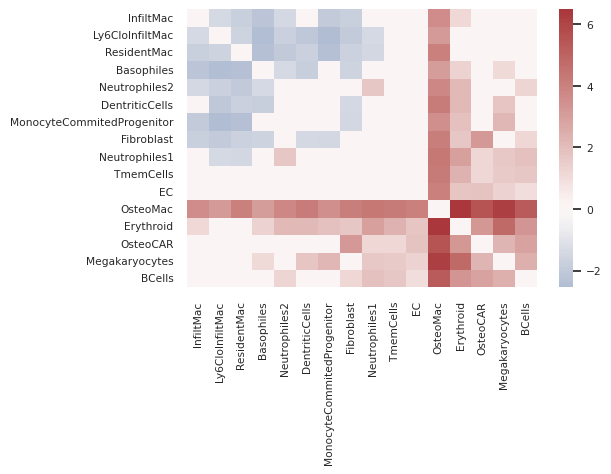

In [17]:
OvsE_TPO_HMdf=nichesphere.tl.OvsE_coloc_test(observedColocProbs=colocPerSample.loc['TPO'], expectedColocProbs=scCTpairsProbs_TPO.annotation, cell_types=CTprops.columns, 
                              testDistribution=test, oneCTinteractions=oneCTints)

# Plot heatmap
sns.set(font_scale=0.7)
sns.heatmap(OvsE_TPO_HMdf.loc[OvsE_TPO_HMdf.columns[plot.dendrogram_col.reordered_ind], OvsE_TPO_HMdf.columns[plot.dendrogram_col.reordered_ind]], 
            cmap='vlag', center=0, vmin=plot.data.min().min(), vmax=plot.data.max().max())
plt.setp(plot.ax_heatmap.yaxis.get_majorticklabels(), rotation=1)
plt.tight_layout()
plt.savefig('./figures/OvsE_TPO.png')
plt.show()

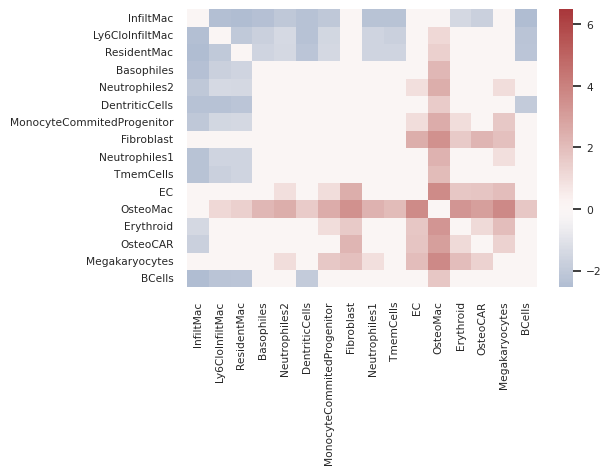

In [18]:
# EV
OvsE_EV_HMdf=nichesphere.tl.OvsE_coloc_test(observedColocProbs=colocPerSample.loc['EV'], expectedColocProbs=scCTpairsProbs_EV.annotation, cell_types=CTprops.columns, 
                              testDistribution=test, oneCTinteractions=oneCTints)
## Plot heatmap
sns.set(font_scale=0.7)
sns.heatmap(OvsE_EV_HMdf.loc[OvsE_TPO_HMdf.columns[plot.dendrogram_col.reordered_ind], OvsE_TPO_HMdf.columns[plot.dendrogram_col.reordered_ind]], 
            cmap='vlag', center=0, vmin=plot.data.min().min(), vmax=plot.data.max().max())
plt.setp(plot.ax_heatmap.yaxis.get_majorticklabels(), rotation=1)
plt.tight_layout()
plt.savefig('./figures/OvsE_EV.png')
plt.show()

Cell groups 

We can define different cell groups and visualise them with different colors in the colocalisation network

In [19]:
immune=np.setdiff1d(CTprops.columns, ['EC', 'Fibroblast', 'OsteoCAR']).tolist()
stromal=['EC', 'Fibroblast', 'OsteoCAR']
cellGroups={'stromal':stromal, 'immune':immune}

Colocalisation network

To build the colocalisation network, we will get an adjacency matrix (adj) based on the cosine similarities of the distributions of differential colocalisation scores for the different cell types

In [20]:
##Cosine similarity plus pseudocount
adj=pd.DataFrame(sklearn.metrics.pairwise.cosine_similarity(OvsE_TPO_HMdf)+1)
adj.index=OvsE_TPO_HMdf.index
adj.columns=OvsE_TPO_HMdf.columns

##Cell pairs with not significant differential colocalisation get 0
adj[OvsE_TPO_HMdf==0]=0
adj[adj==1]=0

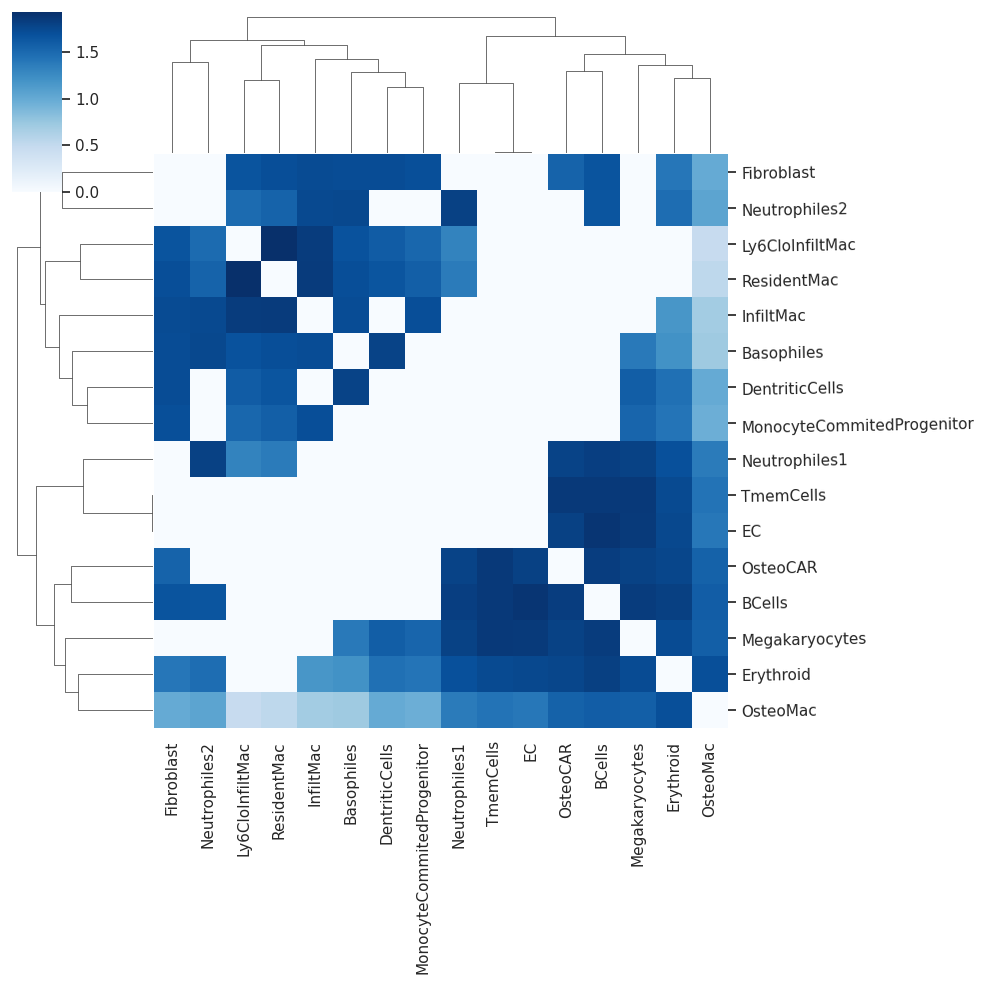

In [21]:
sns.set(font_scale=1)
plot2=sns.clustermap(adj, cmap='Blues', method='average')
plt.setp(plot2.ax_heatmap.yaxis.get_majorticklabels(), rotation=1)
plt.savefig('./figures/adj_TPO.png')
plt.show()

Then the network is built just taking into account the differentially colocalised cell type pairs. The cell groups dictionary can be used here to visualize different cell groups in different colors.

To find niches of differentially colocalised cell types, we can cluster the adjacency matrix / test matrix using hierarchical clustering as shown above. We will take now only the first partition and get 2 clusters

In [22]:
#### Clusters from clustermap on adj
heatClusts=scipy.cluster.hierarchy.fcluster(plot2.dendrogram_col.linkage, 1.1)

#### Clusters dictionary
heatClusts_cellGroups={'0':plot2.dendrogram_col.data.columns[heatClusts==1], '1':plot2.dendrogram_col.data.columns[heatClusts==2]} 

#### Clusters series
colocClusts=pd.Series(heatClusts, index=plot2.dendrogram_col.data.columns)
colocClusts[colocClusts==1]=0
colocClusts[colocClusts==2]=1
colocClusts

DentriticCells                0
InfiltMac                     0
Fibroblast                    0
MonocyteCommitedProgenitor    0
Neutrophiles2                 0
Ly6CloInfiltMac               0
Basophiles                    0
TmemCells                     1
Neutrophiles1                 1
Megakaryocytes                1
ResidentMac                   0
OsteoCAR                      1
EC                            1
Erythroid                     1
OsteoMac                      1
BCells                        1
dtype: int32

Now we can color the nodes in the network by niche

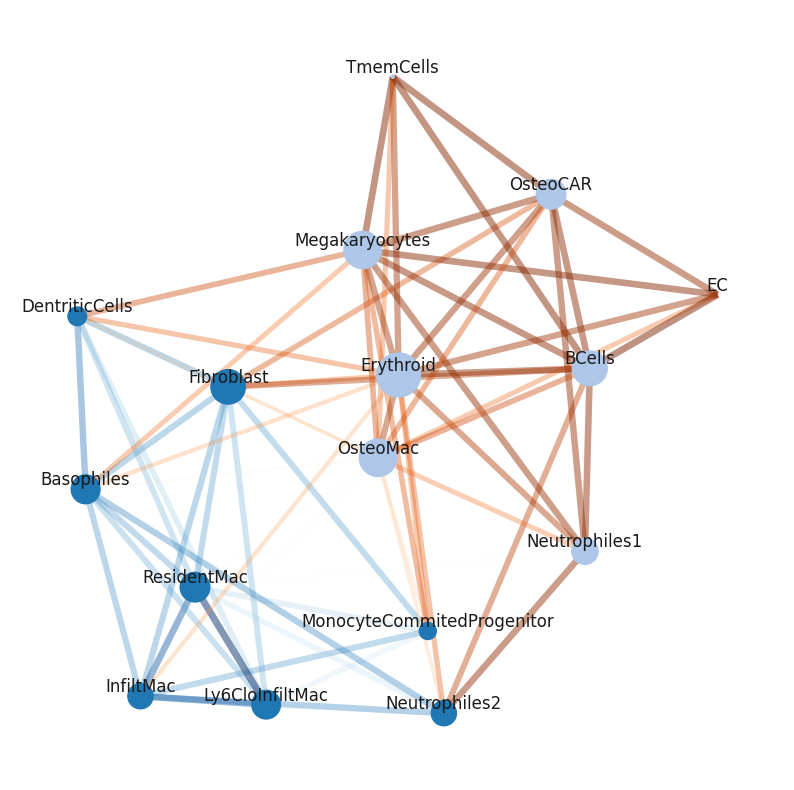

In [23]:
### With adj dendrogram clusters
gCol=nichesphere.tl.colocNW(x_diff=OvsE_TPO_HMdf, adj=adj,cell_group=heatClusts_cellGroups, group_cmap='tab20', ncols=20)
plt.savefig('./figures/diffColocNW_TPO_2adjClusts.png')

In [24]:
#gCol=nichesphere.tl.colocNW(x_diff=OvsE_TPO_HMdf, adj=adj,cell_group=cellGroups, group_cmap='tab20', ncols=20)

We can then calculate some network statistics with the networkX package [ref] functions:

In [25]:
columns=['influencer_score', 'betweenness', 'pagerank', 'degree']
index=list(gCol.nodes)

In [26]:
t1=pd.DataFrame({'influencer':[nx.eigenvector_centrality(gCol)[x] for x in list(gCol.nodes)], 'betweenness':[nx.betweenness_centrality(gCol)[x] for x in list(gCol.nodes)], 
                 'degree':[nx.degree_centrality(gCol)[x] for x in list(gCol.nodes)], 'pagerank':[nx.pagerank(gCol)[x] for x in list(gCol.nodes)]})
t1.index=list(gCol.nodes)

And visualize them

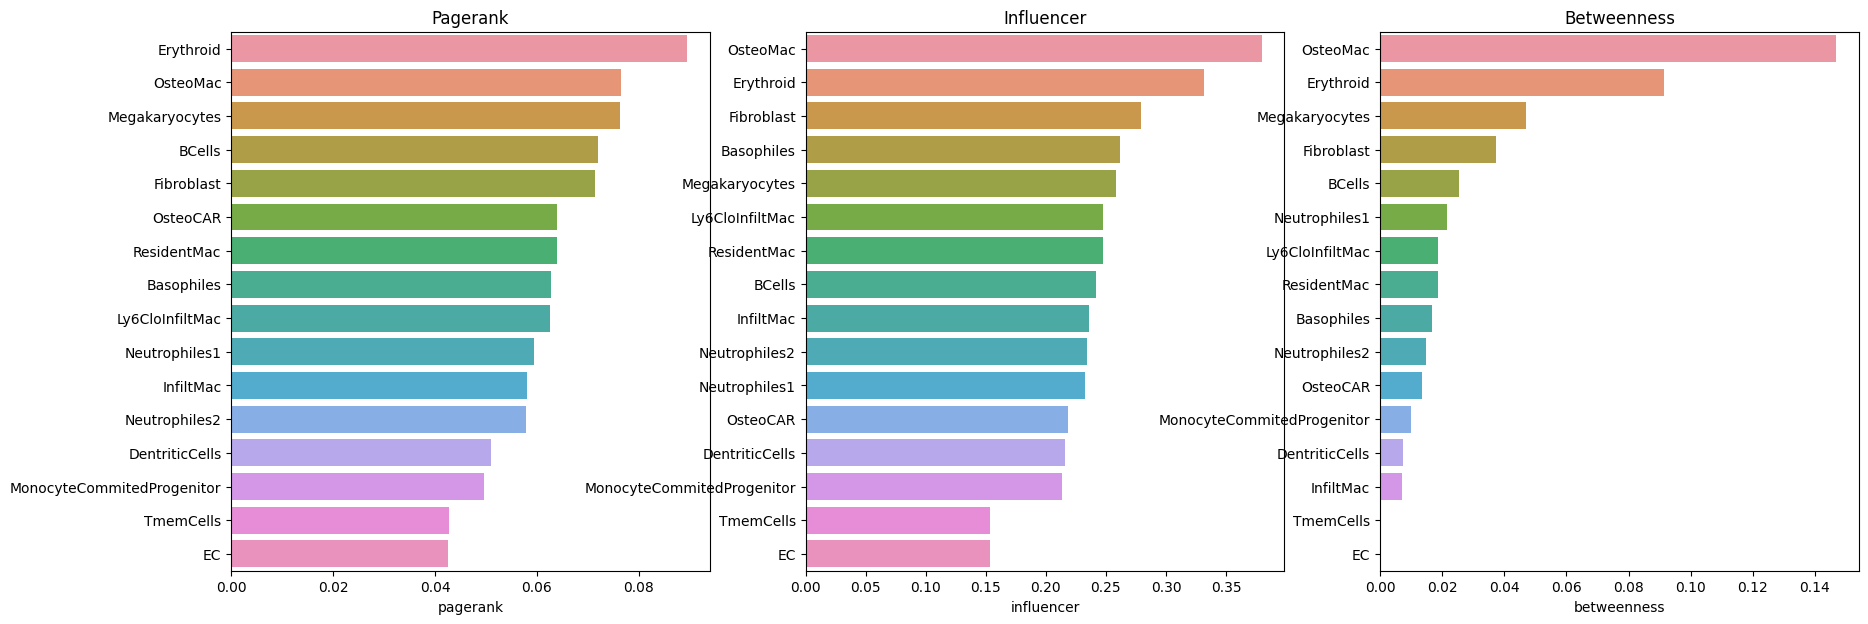

In [27]:
plt.style.use('default')
fig, axes = plt.subplots(1, 3, figsize=(21, 7))
sns.barplot(ax=axes[0], y=t1.sort_values('pagerank', ascending=False).index, x='pagerank', data=t1.sort_values('pagerank', ascending=False))
axes[0].set_title('Pagerank')
sns.barplot(ax=axes[1], y=t1.sort_values('influencer', ascending=False).index, x='influencer', data=t1.sort_values('influencer', ascending=False))
axes[1].set_title('Influencer')
sns.barplot(ax=axes[2], y=t1.sort_values('betweenness', ascending=False).index, x='betweenness', data=t1.sort_values('betweenness', ascending=False))
axes[2].set_title('Betweenness')
plt.savefig('./figures/diffColocNW_stats.png')

To filter the communication data, we will make a binary vector indicating whether each cell type pair is differentially colocalised

In [28]:
# Some functions, like the one for creating the colocalisation binary element, require a cell type pairs data frame where the column containing the cell type pairs is called 'pairs' and cell type pairs are separated by an arrow ('->'):
pairsDir=[]
for ct in CTcolocalizationP.columns[range(len(CTcolocalizationP.columns)-1)]:
    for ct2 in CTcolocalizationP.columns[range(len(CTcolocalizationP.columns)-1)]:
        pairsDir.append(ct+'->'+ct2)
pairCatDFdir=pd.DataFrame(pairsDir, columns=['pairs'])
pairCatDFdir
#pairCatDFdir['cats']=''

,pairs
0,DentriticCells->DentriticCells
1,DentriticCells->InfiltMac
2,DentriticCells->Fibroblast
3,DentriticCells->MonocyteCommitedProgenitor
4,DentriticCells->Neutrophiles2
...,...
251,BCells->OsteoCAR
252,BCells->EC
253,BCells->Erythroid
254,BCells->OsteoMac


In [29]:
## To filter communication data (network)
colocFilt=nichesphere.tl.getColocFilter(pairCatDF=pairCatDFdir, adj=adj, oneCTints=oneCTints.str.replace('-', '->'))
colocFilt.to_csv('./colocalisation_filter.csv')
colocFilt

,filter
pairs,
DentriticCells->DentriticCells,1.0
DentriticCells->InfiltMac,0.0
DentriticCells->Fibroblast,1.0
DentriticCells->MonocyteCommitedProgenitor,0.0
DentriticCells->Neutrophiles2,0.0
...,...
BCells->OsteoCAR,1.0
BCells->EC,1.0
BCells->Erythroid,1.0


In [30]:
#############################

Then we can also define different interaction categories depending on the interacting niches

In [31]:
pairCatDFdir['colocCats']=''
pairCatDFdir['colocCats'][[nichesphere.tl.cellCatContained(pair=p, cellCat=colocClusts.index[colocClusts==0]) for p in pairCatDFdir.pairs]]='0->0'
pairCatDFdir['colocCats'][[nichesphere.tl.cellCatContained(pair=p, cellCat=colocClusts.index[colocClusts==1]) for p in pairCatDFdir.pairs]]='1->1'

pairCatDFdir['colocCats'][[(p.split('->')[0] in colocClusts.index[colocClusts==0]) & (p.split('->')[1] in colocClusts.index[colocClusts==1]) for p in pairCatDFdir.pairs]]='0->1'
pairCatDFdir['colocCats'][[(p.split('->')[1] in colocClusts.index[colocClusts==0]) & (p.split('->')[0] in colocClusts.index[colocClusts==1]) for p in pairCatDFdir.pairs]]='1->0'

## **Communication**

Get cell communication data (CrossTalkeR tables)

In [32]:
crossTalker_ctrlComm=pd.read_csv('./PICseq_crossTalker_newTbl_EV_1.csv')

crossTalker_ctrlComm['gene_A']=crossTalker_ctrlComm['gene_A'].str.replace('\\|L', '')
crossTalker_ctrlComm['gene_A']=crossTalker_ctrlComm['gene_A'].str.replace('\\|R', '')
crossTalker_ctrlComm['gene_B']=crossTalker_ctrlComm['gene_B'].str.replace('\\|R', '')
crossTalker_ctrlComm['gene_B']=crossTalker_ctrlComm['gene_B'].str.replace('\\|TF', '')


crossTalker_tpoComm=pd.read_csv('./PICseq_crossTalker_newTbl_TPO_1.csv')

crossTalker_tpoComm['gene_A']=crossTalker_tpoComm['gene_A'].str.replace('\\|L', '')
crossTalker_tpoComm['gene_A']=crossTalker_tpoComm['gene_A'].str.replace('\\|R', '')
crossTalker_tpoComm['gene_B']=crossTalker_tpoComm['gene_B'].str.replace('\\|R', '')
crossTalker_tpoComm['gene_B']=crossTalker_tpoComm['gene_B'].str.replace('\\|TF', '')

Names of cell types need to match between communication and colocalisation data

In [33]:
## Eliminate skeletal muscle cells as before 
crossTalker_ctrlComm=crossTalker_ctrlComm[crossTalker_ctrlComm.allpair.str.contains('SkletalMusCells')==False]
crossTalker_tpoComm=crossTalker_tpoComm[crossTalker_tpoComm.allpair.str.contains('SkletalMusCells')==False]

Load the tables from the different ligand databases and concatenate them

In [34]:
## matrissome
matrissome=pd.read_csv('/home/mayra/ligandDBs/matrissome/matrissomeDB_processed.csv', index_col=0)
matrissome.Ligand=matrissome.Ligand.str.lower()
matrissome=matrissome.drop_duplicates()
matrissome['db']='matrissome'

In [35]:
## cytosig
cytosig=pd.read_csv('/home/mayra/ligandDBs/cytosig/CytoSigDB_processed.csv', index_col=0)
#cytosig.Ligand=cytosig.Ligand.str.lower()
cytosig['db']='cytosig'
cytosig=cytosig[['Ligand', 'category', 'db']]

In [36]:
## together
allDBs=pd.concat([matrissome, cytosig])
allDBs

,Ligand,category,db
1,gene,Collagens,matrissome
2,col1a1,Collagens,matrissome
5,col1a2,Collagens,matrissome
17,col6a3,Collagens,matrissome
23,col3a1,Collagens,matrissome
...,...,...,...
526,PTGES,Inhibitory,cytosig
536,PTGS2,Inhibitory,cytosig
546,PTGS2,Inhibitory,cytosig
555,PTGS2,Inhibitory,cytosig


Then we'll calculate communication scores summing scores for a specific LR pair for a specific cell type pair and separate these scores per ligand category to know which cell type pairs are interacting through which mechanisms.

In [37]:
EV_CTpairScores_byCat2_dir_colocClusts=nichesphere.tl.lr_ctPairScores_perCat_dir(ccommTable=crossTalker_ctrlComm, db=allDBs, dbCatCol='category', dbMatchCol='Ligand', 
                        ccommMatchCol='gene_A', ccommLRscoresCol='MeanLR', oneCTinteractions=oneCTints.str.replace('-', '@'), condition='EV', pairCatDF=pairCatDFdir)

In [38]:
tpoCTpairScores_byCat2_dir_colocClusts=nichesphere.tl.lr_ctPairScores_perCat_dir(ccommTable=crossTalker_tpoComm, db=allDBs, dbCatCol='category', dbMatchCol='Ligand', 
                        ccommMatchCol='gene_A', ccommLRscoresCol='MeanLR', oneCTinteractions=oneCTints.str.replace('-', '@'), condition='TPO', pairCatDF=pairCatDFdir)

Some interactions might be present only in one condition, so we will assign 0 values to the interactions that do not appear in one condition to be able to compare conditions

In [39]:
EV_CTpairScores_byCat2_dir_colocClusts, tpoCTpairScores_byCat2_dir_colocClusts = nichesphere.tl.equalizeScoresTables(ctrlTbl=EV_CTpairScores_byCat2_dir_colocClusts, 
                                                    expTbl=tpoCTpairScores_byCat2_dir_colocClusts, ctrlCondition='EV', expCondition='TPO')

Filter by colocalisation

In [40]:
EV_CTpairScores_byCat2_dir_colocClusts=EV_CTpairScores_byCat2_dir_colocClusts[[i in colocFilt.index[colocFilt['filter']==1] for i in EV_CTpairScores_byCat2_dir_colocClusts.pairs]]
tpoCTpairScores_byCat2_dir_colocClusts=tpoCTpairScores_byCat2_dir_colocClusts[[i in colocFilt.index[colocFilt['filter']==1] for i in tpoCTpairScores_byCat2_dir_colocClusts.pairs]]

Then we can test for differential cell cell communication across mechanisms and cell groups with the function 'tl.diffCcommStats' and plot the resulting scores as follows:

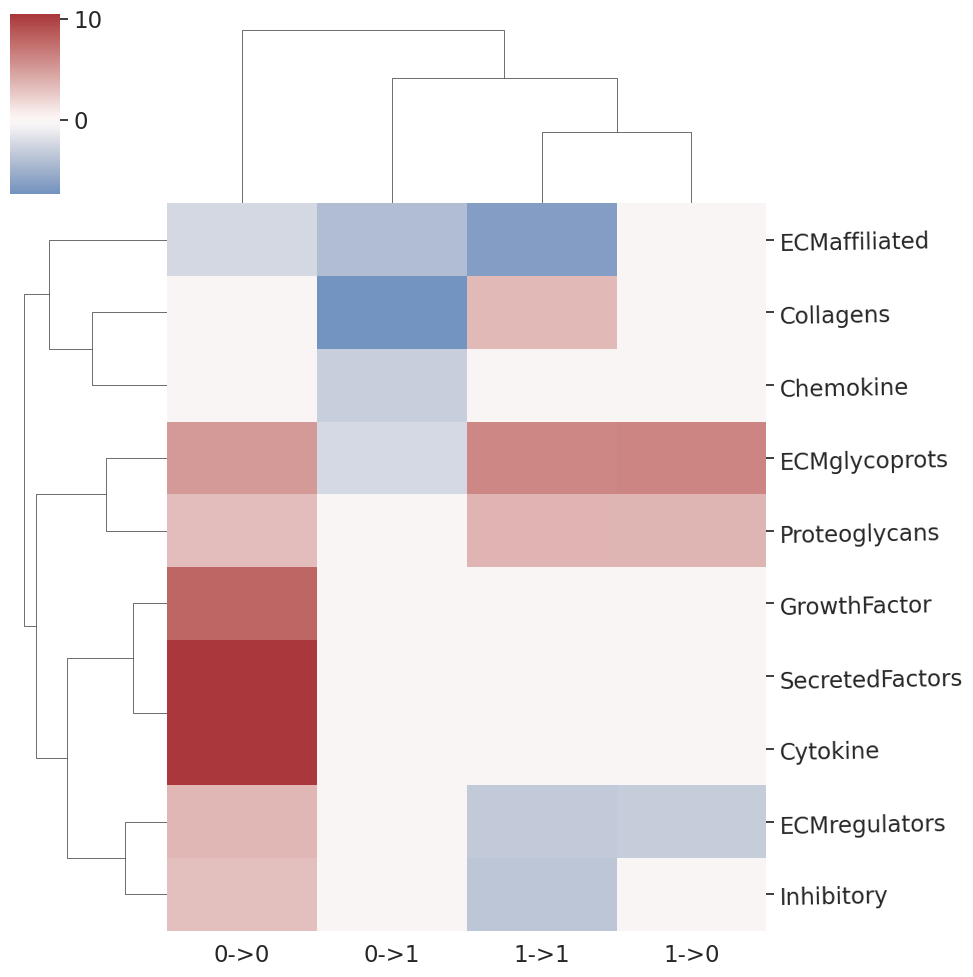

In [41]:
## Differential communication by coloc group

## Differential communication statistics
EVtpo_diffCcommTable_colocGroups_dir=nichesphere.tl.diffCcommStats(c1CTpairScores_byCat=tpoCTpairScores_byCat2_dir_colocClusts, c2CTpairScores_byCat=EV_CTpairScores_byCat2_dir_colocClusts, cellCatCol='colocCats')

## Plot in heatmap
nichesphere.tl.plotDiffCcommStatsHM(diffCommTable=EVtpo_diffCcommTable_colocGroups_dir, min_pval=0.05)
plt.savefig('./figures/colocFiltereddiffComm_colocClusts_categories.png')
plt.show()

These statistics can also be shown in boxplots

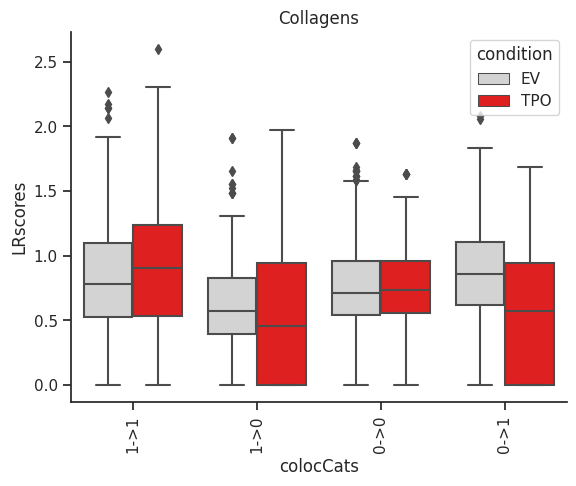

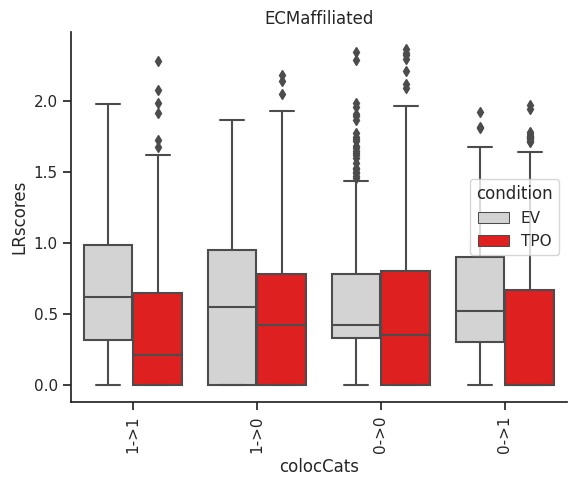

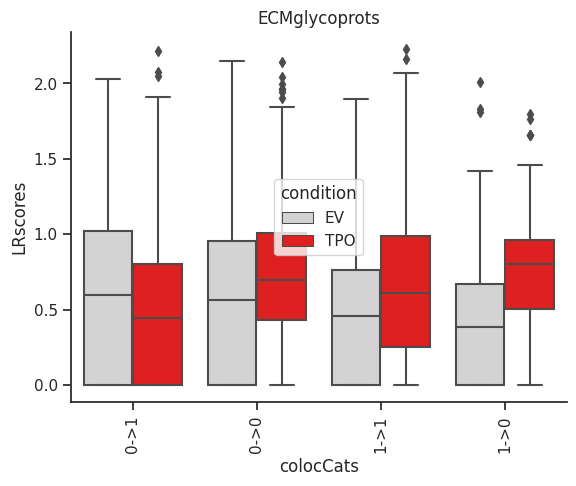

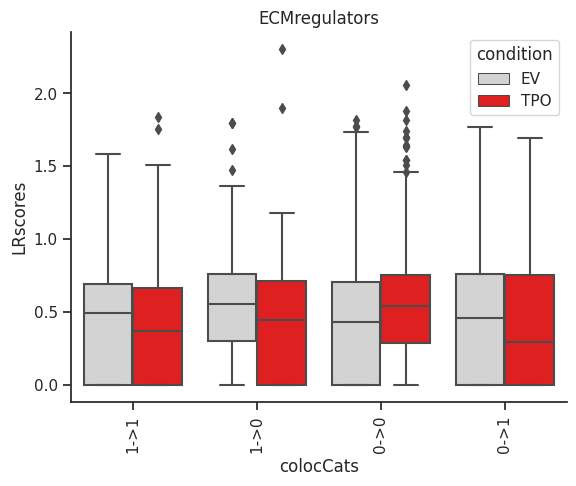

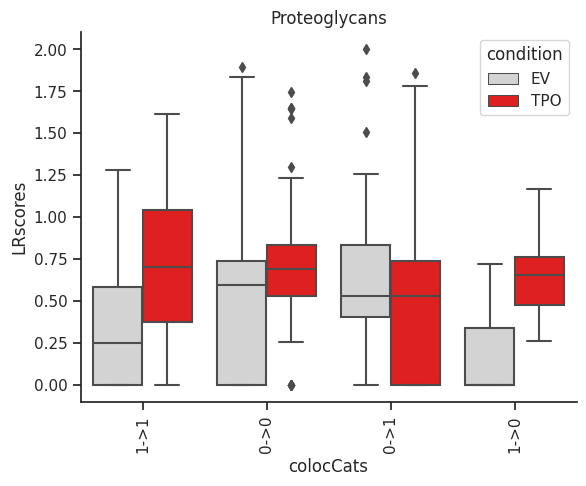

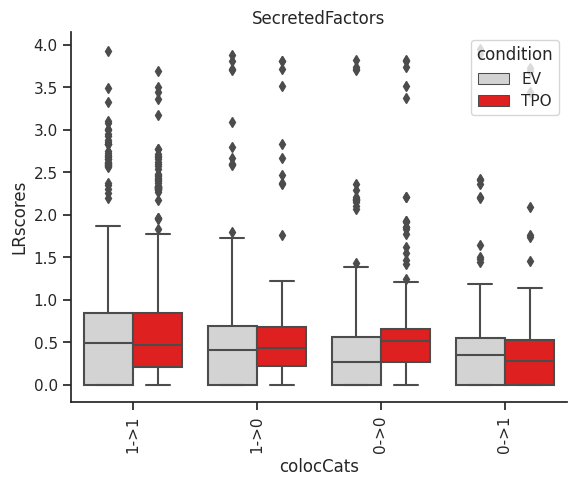

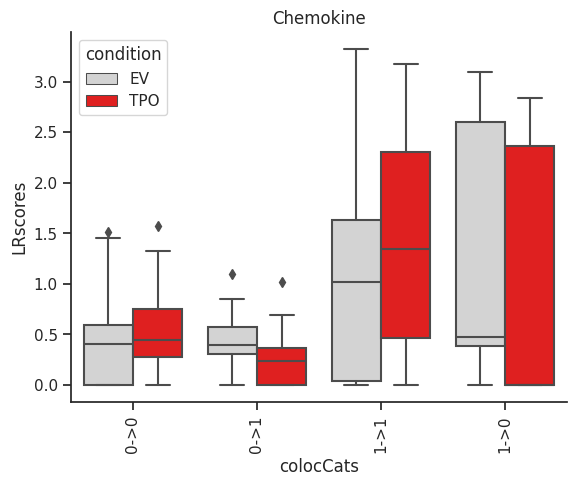

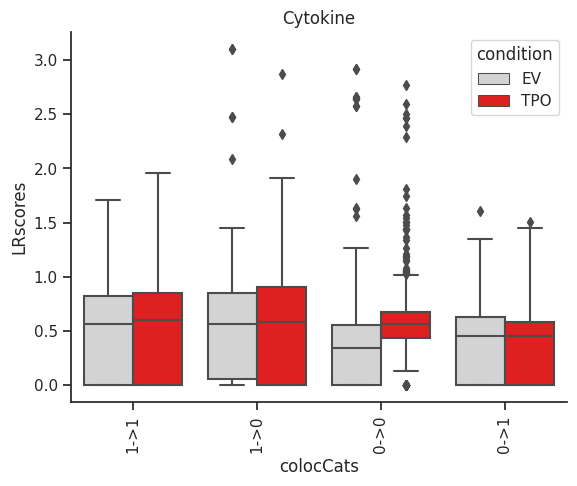

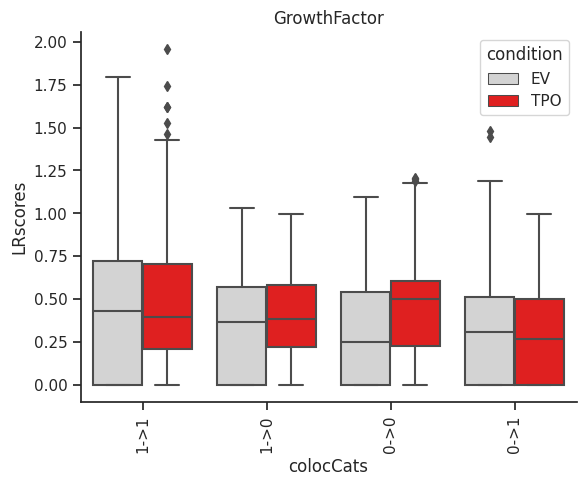

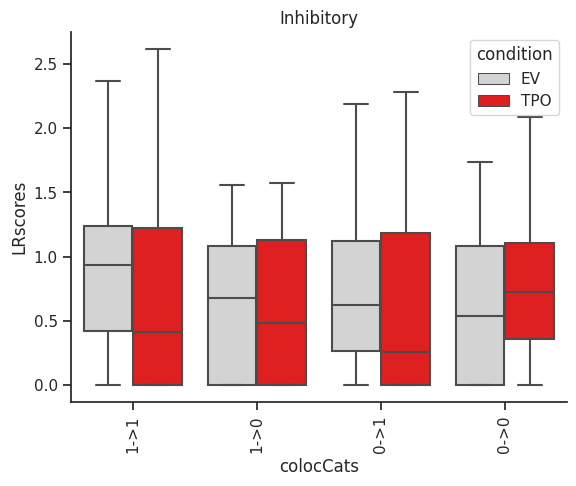

In [42]:
## First we concatenate the dataframes of statistics for each condition
boxplotDF=pd.concat([EV_CTpairScores_byCat2_dir_colocClusts, tpoCTpairScores_byCat2_dir_colocClusts])
#boxplotDF.to_csv('/home/mayra/wng2_wsm/ccomm_EV_x_thpo_cytosig.csv')
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
## Define a color per condition
my_colors = {'EV': 'lightgray', 'TPO': 'red'}
## Then we can do boxplots for the different Ligand categories
for cat in boxplotDF.LRcat.unique():
    sns.set_theme(style="ticks", rc=custom_params)
    sns.boxplot(data=boxplotDF[boxplotDF.LRcat==cat], x='colocCats', y='LRscores', hue='condition', palette=my_colors, dodge=True).set(title=cat)
    plt.xticks(rotation=90)
    plt.savefig('./figures/diffCcomm_EV_x_thpo_'+cat+'.png', bbox_inches='tight')
    plt.show()


In [43]:
#boxplotDF.pairs[(boxplotDF.colocCats=='1->0') & (boxplotDF.LRcat=='ECMglycoprots')]
boxplotDF.pairs[(boxplotDF.colocCats=='1->1') & (boxplotDF.LRcat=='ECMaffiliated') & (boxplotDF.LRscores>0)]

allpair
BCells/Lgals1@EC/Itgb1                                  BCells->EC
BCells/Lgals1@Erythroid/Itgb1                    BCells->Erythroid
BCells/Lgals1@OsteoCAR/Itgb1                      BCells->OsteoCAR
BCells/Lgals1@OsteoMac/Itgb1                      BCells->OsteoMac
BCells/Lgals1@TmemCells/Ptprc                    BCells->TmemCells
                                                   ...            
TmemCells/Lgals9@OsteoCAR/Slc1a5               TmemCells->OsteoCAR
TmemCells/Sema4a@OsteoCAR/Nrp1*Plxna2          TmemCells->OsteoCAR
TmemCells/Sema4a@OsteoCAR/Plxnd1               TmemCells->OsteoCAR
TmemCells/Sema4d@BCells/Cd72                     TmemCells->BCells
TmemCells/Sema4d@Megakaryocytes/Cd72     TmemCells->Megakaryocytes
Name: pairs, Length: 323, dtype: object

Next, we can look at differential cell communication per cell type pair in each ligand category

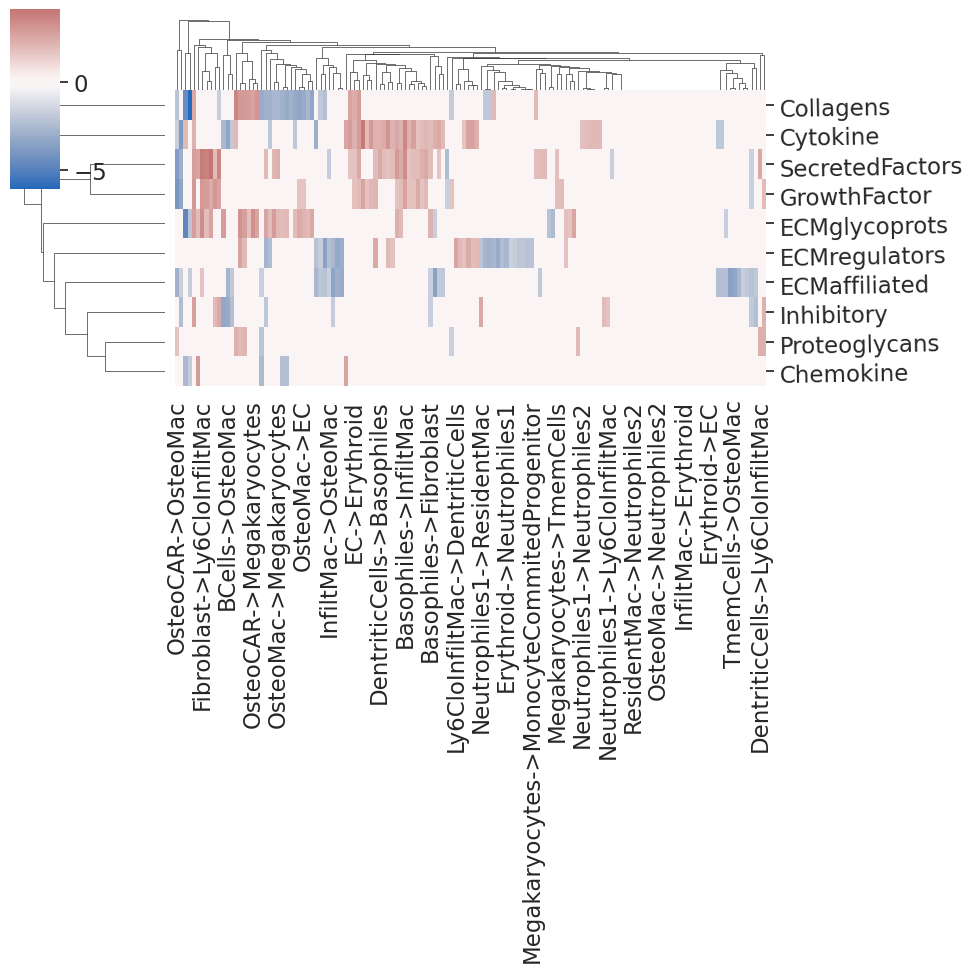

In [44]:
## Differential cell communication per cell type pair

## Differential communication statistics
EVtpo_diffCcommTable2_CTpair_dir=nichesphere.tl.diffCcommStats(c1CTpairScores_byCat=tpoCTpairScores_byCat2_dir_colocClusts, c2CTpairScores_byCat=EV_CTpairScores_byCat2_dir_colocClusts, cellCatCol='pairs')

## Plot in heatmap, get heatmap data
x_EVtpo_dir=nichesphere.tl.plotDiffCcommStatsHM(diffCommTable=EVtpo_diffCcommTable2_CTpair_dir, min_pval=0.1)

In [45]:
x_EVtpo_dir.index

Index(['Collagens', 'ECMaffiliated', 'ECMglycoprots', 'ECMregulators',
       'Proteoglycans', 'SecretedFactors', 'Chemokine', 'Cytokine',
       'GrowthFactor', 'Inhibitory'],
      dtype='object')

We can also plot Ligand-Receptor based cellular interactions per mechanism on the colocalisation network after filtering the communication data

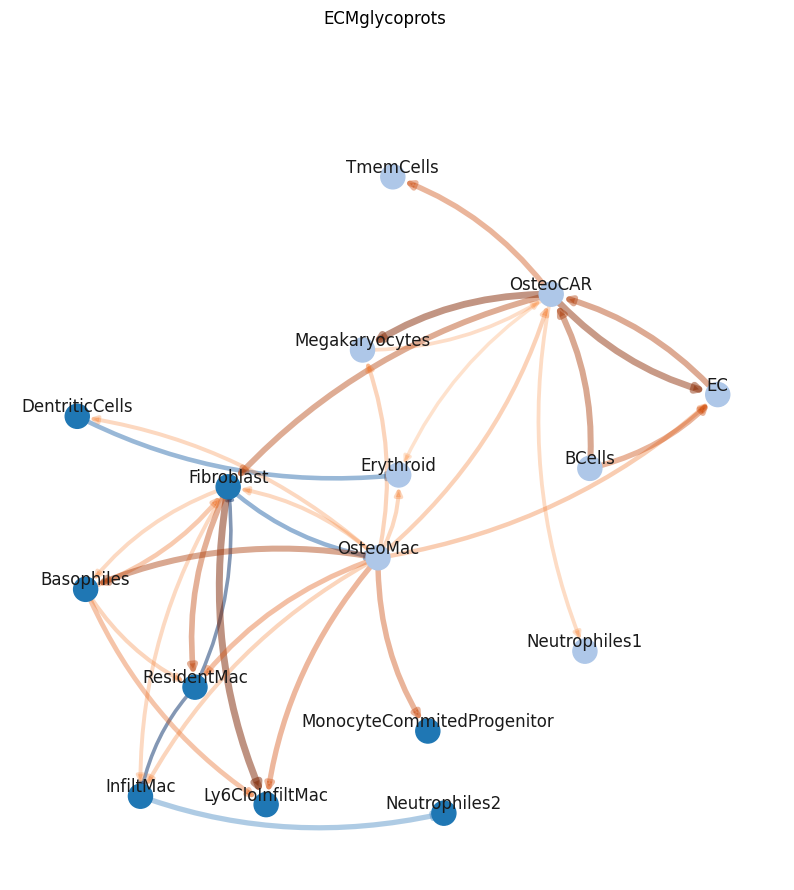

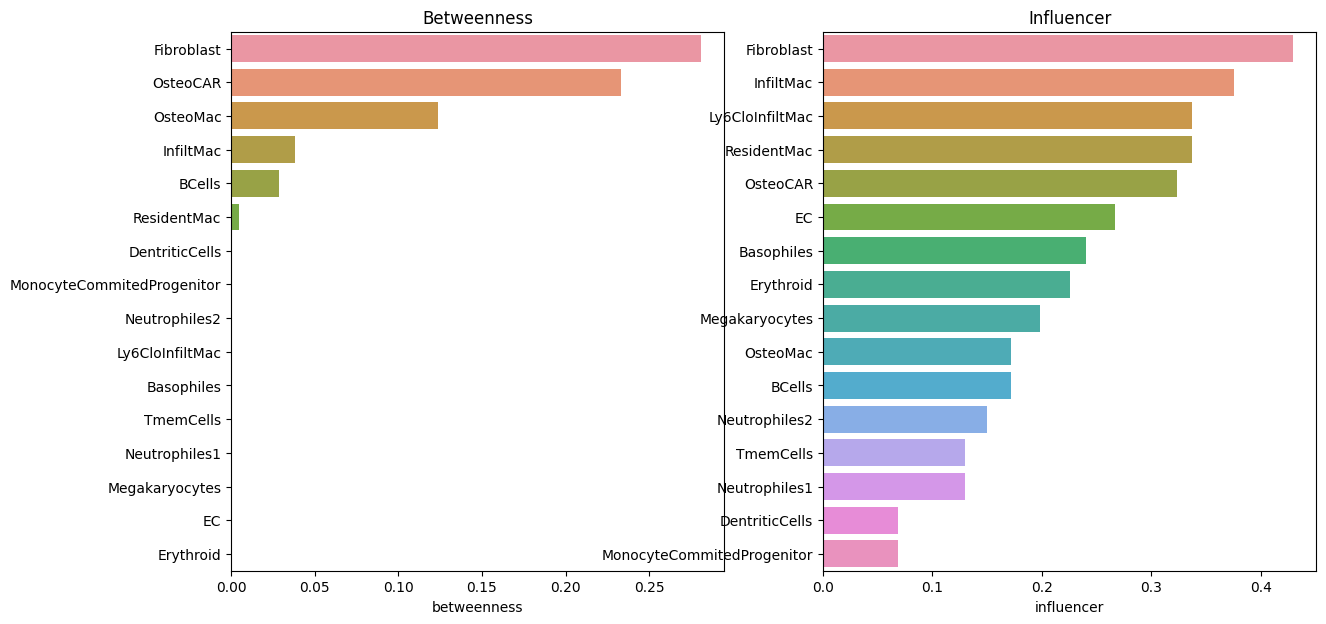

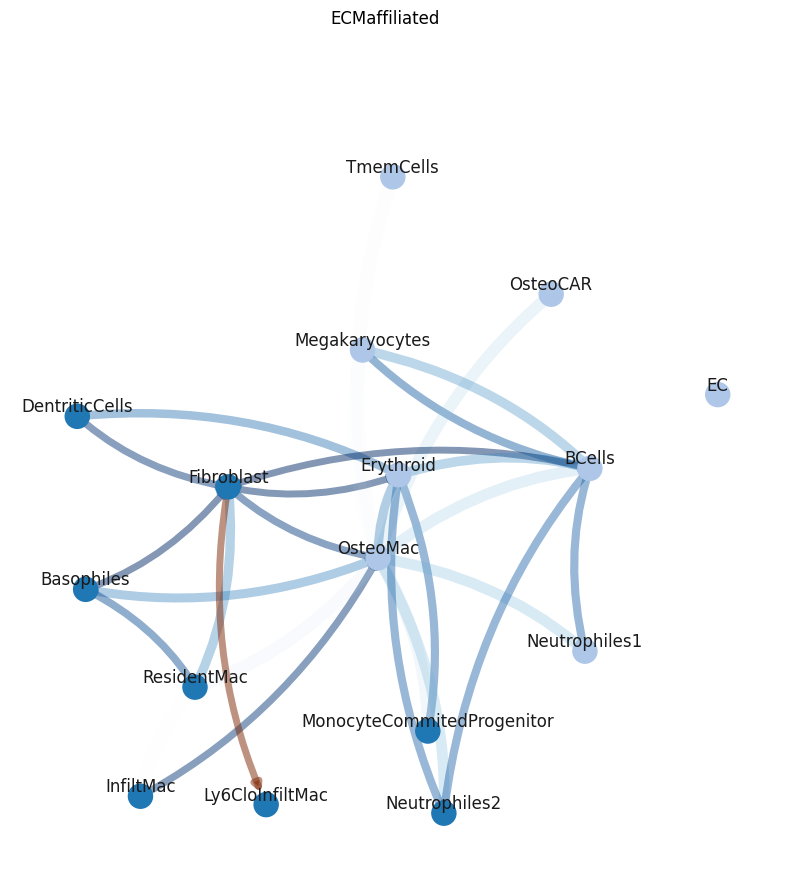

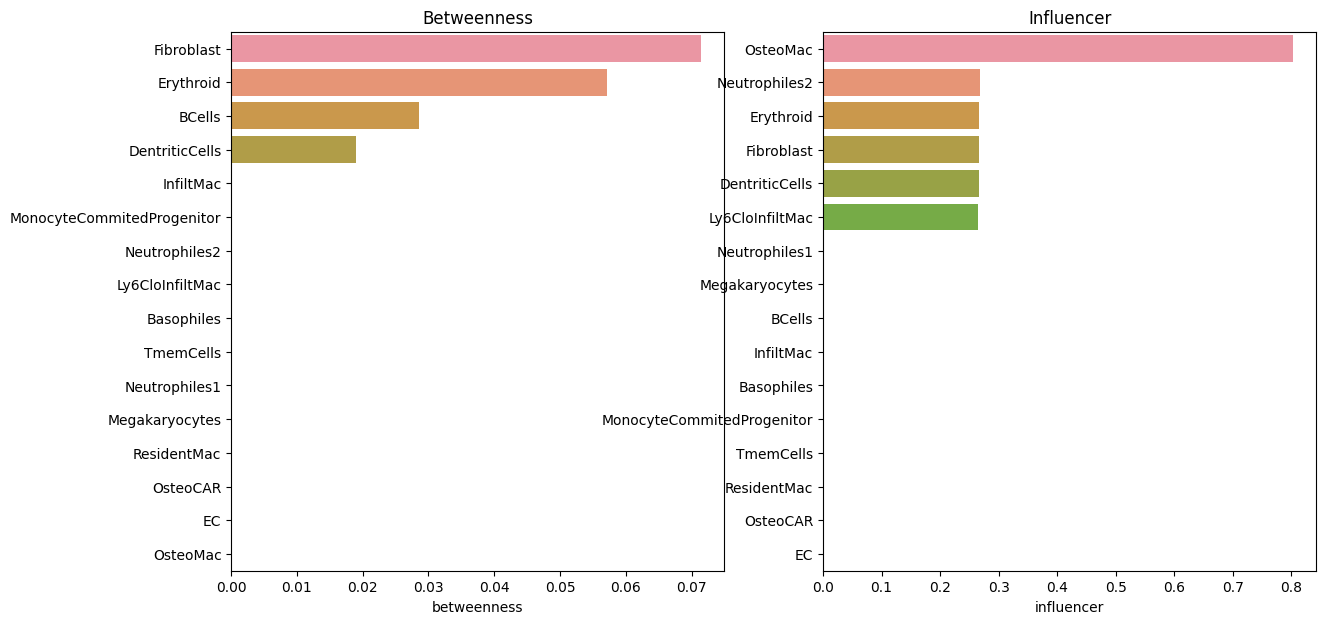

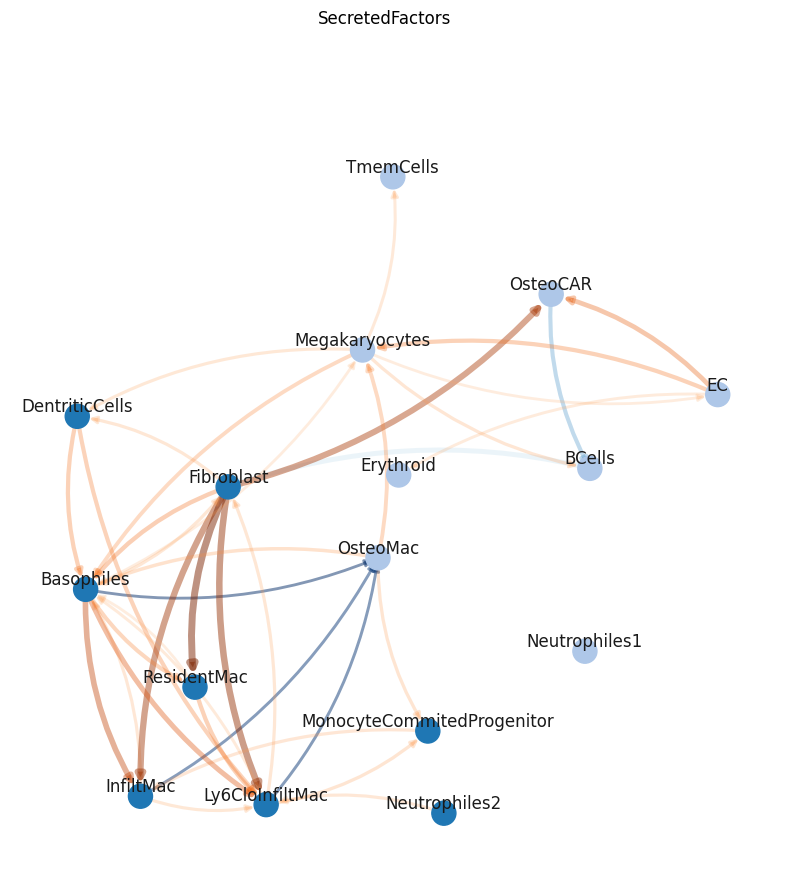

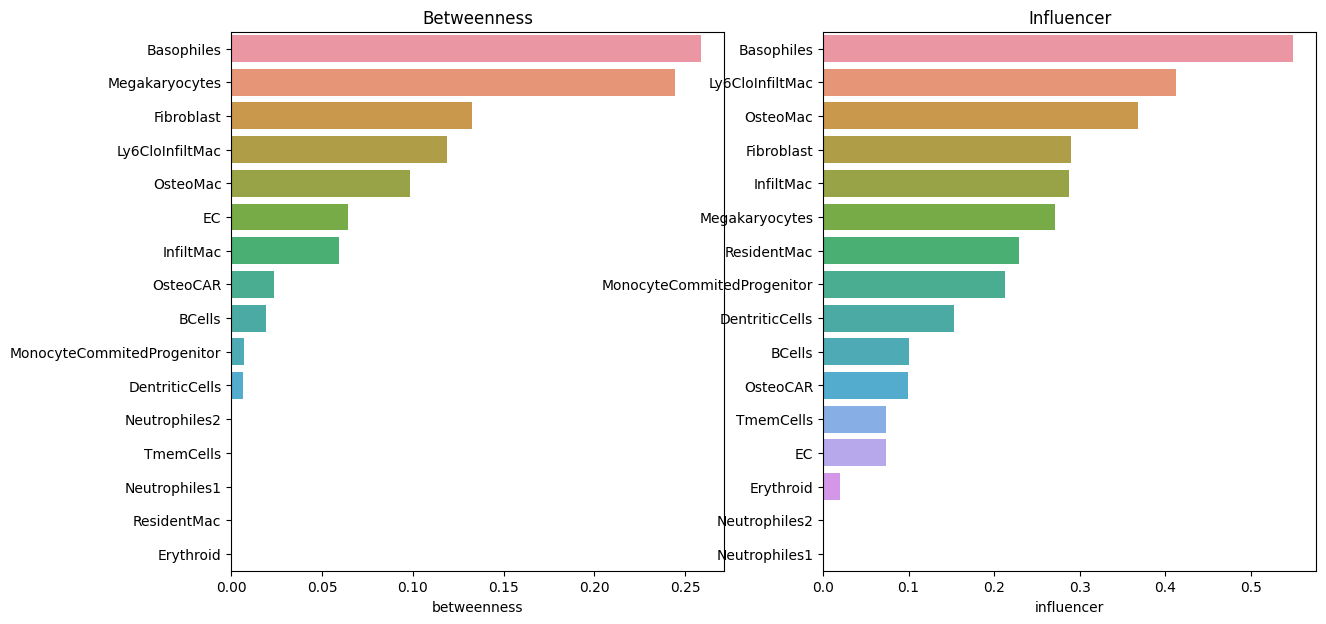

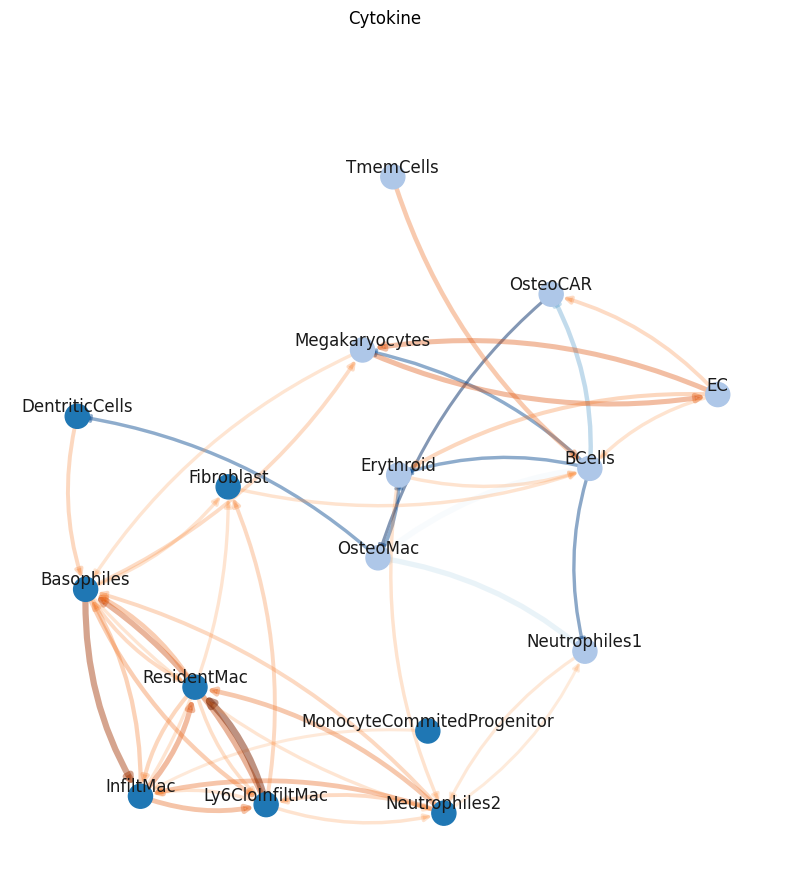

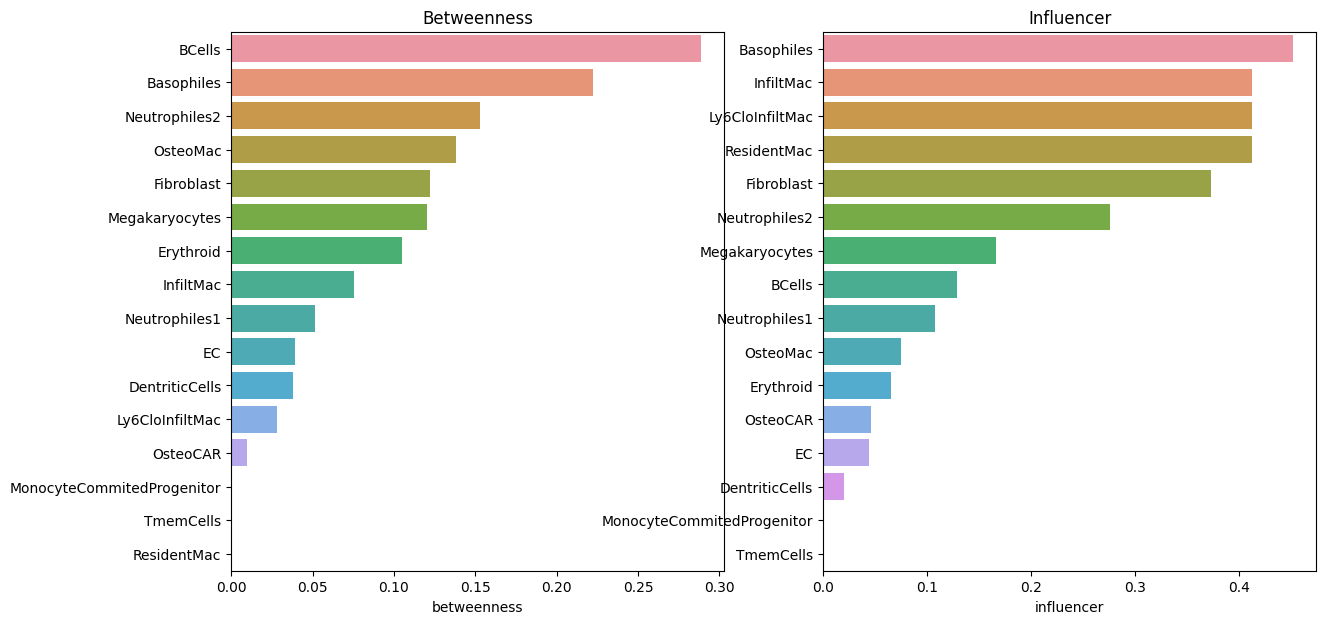

In [46]:
### Just one ligand category at a time
#for cat in x_EVtpo_dir.index:
for cat in ['ECMglycoprots', 'ECMaffiliated', 'SecretedFactors', 'Cytokine']:
    #we will first get a matrix of differential communication scores (x_chem) from a selected ligand category and the corresponding adjacency matrix (adjChem) 
    x_chem,adjChem=nichesphere.tl.getAdj_comm(diffCommTbl=x_EVtpo_dir, pairCatDF=pairCatDFdir, ncells=16, cat=cat, p=0.1)
    #Then we can plot the differential communication scores of that category in a heatmap
    #And visualize these ligand-receptor interactions as edges in the colocalisation network
    plt.style.use('default')
    plt.setp(plot.ax_heatmap.yaxis.get_majorticklabels(), rotation=1)
    G=nichesphere.tl.catNW(x_chem=x_chem,colocNW=gCol, cell_group=heatClusts_cellGroups, group_cmap='tab20', ncols=20, plot_title=cat)
    plt.savefig('./figures/colocFilt_commNW_'+cat+'.png')
    plt.show()
    
    t1=pd.DataFrame({'betweenness':[nx.betweenness_centrality(G)[x] for x in list(G.nodes)], 'influencer':[nx.eigenvector_centrality(G, max_iter=1000)[x] for x in list(G.nodes)],
                 'degree':[nx.degree_centrality(G)[x] for x in list(G.nodes)], 'pagerank':[nx.pagerank(G)[x] for x in list(G.nodes)]})
    t1.index=list(G.nodes)
    plt.style.use('default')
    fig, axes = plt.subplots(1, 2, figsize=(14, 7))
    sns.barplot(ax=axes[0], y=t1.sort_values('betweenness', ascending=False).index, x='betweenness', data=t1.sort_values('betweenness', ascending=False))
    axes[0].set_title('Betweenness')
    #sns.barplot(ax=axes[0], y=t1.sort_values('pagerank', ascending=False).index, x='pagerank', data=t1.sort_values('pagerank', ascending=False))
    #axes[0].set_title('Pagerank')
    sns.barplot(ax=axes[1], y=t1.sort_values('influencer', ascending=False).index, x='influencer', data=t1.sort_values('influencer', ascending=False))
    axes[1].set_title('Influencer')
    plt.savefig('./figures/nwStats_'+cat+'.png')